1. Khai báo thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cài đặt cho biểu đồ đẹp hơn
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

2. Tải và kiểm tra dữ liệu

In [2]:
# Tải dữ liệu
file_path = 'CA_Weather_Fire_Dataset_Clean2.csv'
df = pd.read_csv(file_path)

# Chuyển cột DATE sang dạng datetime để xử lý nếu cần
df['DATE'] = pd.to_datetime(df['DATE'])

# Hiển thị 5 dòng đầu tiên
print(df.head())
print("\nThông tin bộ dữ liệu:")
df.info()

        DATE  PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  \
0 1984-01-01            0.0      79.0      51.0            4.70   
1 1984-01-02            0.0      71.0      46.0            5.59   
2 1984-01-03            0.0      70.0      47.0            5.37   
3 1984-01-04            0.0      76.0      45.0            4.70   
4 1984-01-05            0.0      74.0      49.0            5.14   

   FIRE_START_DAY  YEAR  TEMP_RANGE  WIND_TEMP_RATIO  MONTH  SEASON  \
0           False  1984        28.0         0.059494      1  Winter   
1           False  1984        25.0         0.078732      1  Winter   
2           False  1984        23.0         0.076714      1  Winter   
3           False  1984        31.0         0.061842      1  Winter   
4           False  1984        25.0         0.069459      1  Winter   

   LAGGED_PRECIPITATION  LAGGED_AVG_WIND_SPEED  DAY_OF_YEAR  
0                   0.0                  4.700            1  
1                   0.0                  5.145

3. Kỹ thuật đặc trưng (Feature Engineering): Tạo 5 cấp độ cháy

In [3]:
def assign_fire_risk(row):
    """
    Hàm này gán 5 cấp độ rủi ro.
    CHÚNG TA SẼ NỚI LỎNG QUY TẮC CHO CẤP 4 VÀ CẤP 5
    """
    temp = row['MAX_TEMP']
    wind = row['AVG_WIND_SPEED']
    precip = row['PRECIPITATION']
    
    # Cấp 5 (Cực kỳ nguy hiểm): Thử hạ nhiệt độ và gió xuống
    if temp > 90 and wind > 8 and precip == 0:  # Gốc: 95 và 10
        return 5
    # Cấp 4 (Rất nguy hiểm):
    elif temp > 85 and wind > 6 and precip == 0: # Gốc: 90 và 7
        return 4
    # Cấp 3 (Nguy hiểm):
    elif temp > 80 and precip == 0: # Gốc: 85
        return 3
    # Cấp 2 (Trung bình):
    elif temp > 70 or wind > 5: # Gốc: 75 và 8
        return 2
    # Cấp 1 (Thấp):
    else:
        return 1

# Áp dụng hàm này cho mỗi hàng
df['FIRE_RISK_LEVEL'] = df.apply(assign_fire_risk, axis=1)

print("Đã tạo cột 'FIRE_RISK_LEVEL' thành công.")

Đã tạo cột 'FIRE_RISK_LEVEL' thành công.


4. Khám phá biến mục tiêu (Target Variable)

Phân bổ các cấp độ rủi ro:
FIRE_RISK_LEVEL
1      790
2    12951
3      949
4      265
5       21
Name: count, dtype: int64


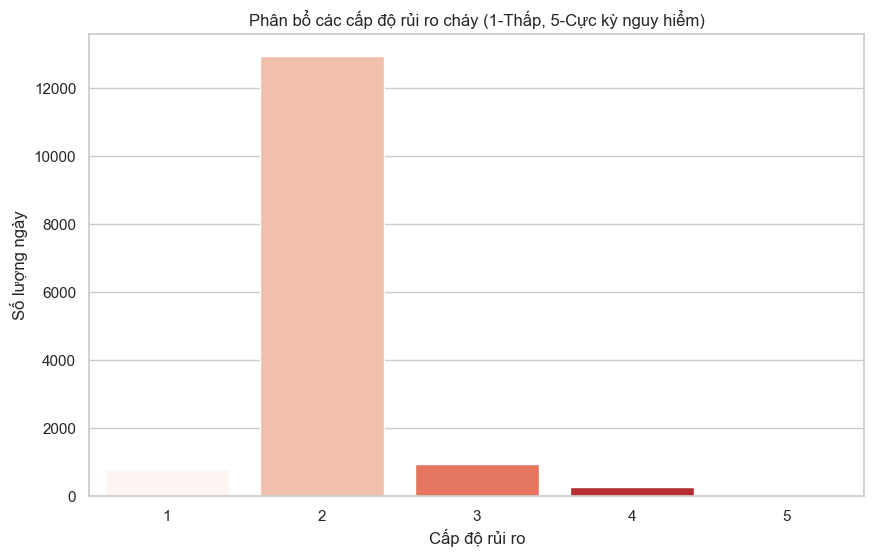

In [4]:
print("Phân bổ các cấp độ rủi ro:")
print(df['FIRE_RISK_LEVEL'].value_counts().sort_index())

# Vẽ biểu đồ
sns.countplot(x='FIRE_RISK_LEVEL', data=df, palette='Reds', 
              hue='FIRE_RISK_LEVEL', legend=False) # <--- ĐÃ SỬA
plt.title('Phân bổ các cấp độ rủi ro cháy (1-Thấp, 5-Cực kỳ nguy hiểm)')
plt.xlabel('Cấp độ rủi ro')
plt.ylabel('Số lượng ngày')
plt.show()

5. Tiền xử lý: Chuẩn bị dữ liệu cho mô hình

In [5]:
# 1. Chọn mục tiêu (y)
y = df['FIRE_RISK_LEVEL']

# 2. Chọn đặc trưng (X)
# Chúng ta sẽ bỏ các cột không liên quan hoặc đã được thay thế
features_to_drop = ['DATE', 'FIRE_START_DAY', 'YEAR', 'FIRE_RISK_LEVEL']
X = df.drop(columns=features_to_drop)

# 3. Mã hóa (One-Hot Encoding) cột 'SEASON'
X = pd.get_dummies(X, columns=['SEASON'], drop_first=True)

print("Dữ liệu X (đặc trưng) sau khi mã hóa:")
print(X.head())

Dữ liệu X (đặc trưng) sau khi mã hóa:
   PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  TEMP_RANGE  \
0            0.0      79.0      51.0            4.70        28.0   
1            0.0      71.0      46.0            5.59        25.0   
2            0.0      70.0      47.0            5.37        23.0   
3            0.0      76.0      45.0            4.70        31.0   
4            0.0      74.0      49.0            5.14        25.0   

   WIND_TEMP_RATIO  MONTH  LAGGED_PRECIPITATION  LAGGED_AVG_WIND_SPEED  \
0         0.059494      1                   0.0                  4.700   
1         0.078732      1                   0.0                  5.145   
2         0.076714      1                   0.0                  5.220   
3         0.061842      1                   0.0                  5.090   
4         0.069459      1                   0.0                  5.100   

   DAY_OF_YEAR  SEASON_Spring  SEASON_Summer  SEASON_Winter  
0            1          False          False  

6. Chia dữ liệu (Train-Test Split)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% dữ liệu dùng để test
    random_state=42,  # Để đảm bảo kết quả có thể tái lập
    stratify=y        # QUAN TRỌNG: Giữ cân bằng tỷ lệ các cấp độ
)

print(f"Kích thước tập huấn luyện (Train): {X_train.shape[0]} mẫu")
print(f"Kích thước tập kiểm tra (Test): {X_test.shape[0]} mẫu")

Kích thước tập huấn luyện (Train): 11980 mẫu
Kích thước tập kiểm tra (Test): 2996 mẫu


7. Xây dựng và Huấn luyện mô hình (Random Forest)

In [7]:
# Khởi tạo mô hình
# n_estimators=100: Sử dụng 100 "cây" quyết định
# random_state=42: Để kết quả nhất quán
# n_jobs=-1: Sử dụng tất cả CPU để chạy nhanh hơn
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Huấn luyện mô hình
print("Bắt đầu huấn luyện mô hình...")
model.fit(X_train, y_train)

print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện mô hình...
Huấn luyện hoàn tất!


8. Đánh giá mô hình

In [8]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác tổng thể (Accuracy): {accuracy * 100:.2f}%\n")

print("--- Báo cáo phân loại chi tiết ---")

target_names = ['Cấp 1', 'Cấp 2', 'Cấp 3', 'Cấp 4', 'Cấp 5']
labels_list = [1, 2, 3, 4, 5]

# Thêm labels=labels_list và zero_division=0
print(classification_report(y_test, y_pred, 
                            target_names=target_names, 
                            labels=labels_list, 
                            zero_division=0))

Độ chính xác tổng thể (Accuracy): 99.83%

--- Báo cáo phân loại chi tiết ---
              precision    recall  f1-score   support

       Cấp 1       1.00      1.00      1.00       158
       Cấp 2       1.00      1.00      1.00      2591
       Cấp 3       0.99      1.00      1.00       190
       Cấp 4       0.93      1.00      0.96        53
       Cấp 5       1.00      0.25      0.40         4

    accuracy                           1.00      2996
   macro avg       0.98      0.85      0.87      2996
weighted avg       1.00      1.00      1.00      2996



9. Trực quan hóa kết quả: Ma trận nhầm lẫn (Confusion Matrix)

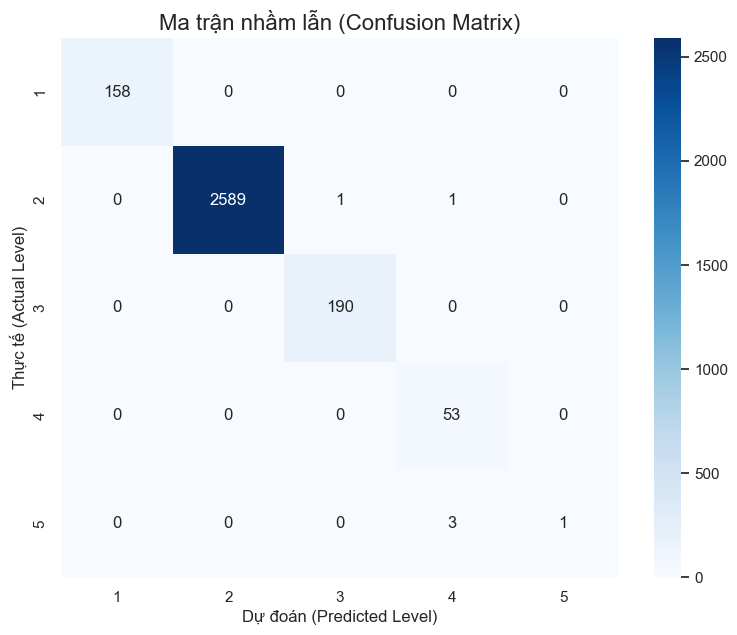

In [9]:
cm = confusion_matrix(y_test, y_pred)
labels = [1, 2, 3, 4, 5]

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Ma trận nhầm lẫn (Confusion Matrix)', fontsize=16)
plt.ylabel('Thực tế (Actual Level)', fontsize=12)
plt.xlabel('Dự đoán (Predicted Level)', fontsize=12)
plt.show()

10. (Bonus) Mức độ quan trọng của đặc trưng

--- Mức độ quan trọng của các đặc trưng ---
                  Feature  Importance
1                MAX_TEMP    0.477333
3          AVG_WIND_SPEED    0.189468
5         WIND_TEMP_RATIO    0.131262
4              TEMP_RANGE    0.074366
2                MIN_TEMP    0.059805
8   LAGGED_AVG_WIND_SPEED    0.023841
9             DAY_OF_YEAR    0.016311
12          SEASON_Winter    0.008308
6                   MONTH    0.006865
7    LAGGED_PRECIPITATION    0.005770


C:\Users\Ngoc Toan\AppData\Local\Temp\ipykernel_28012\1236799970.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


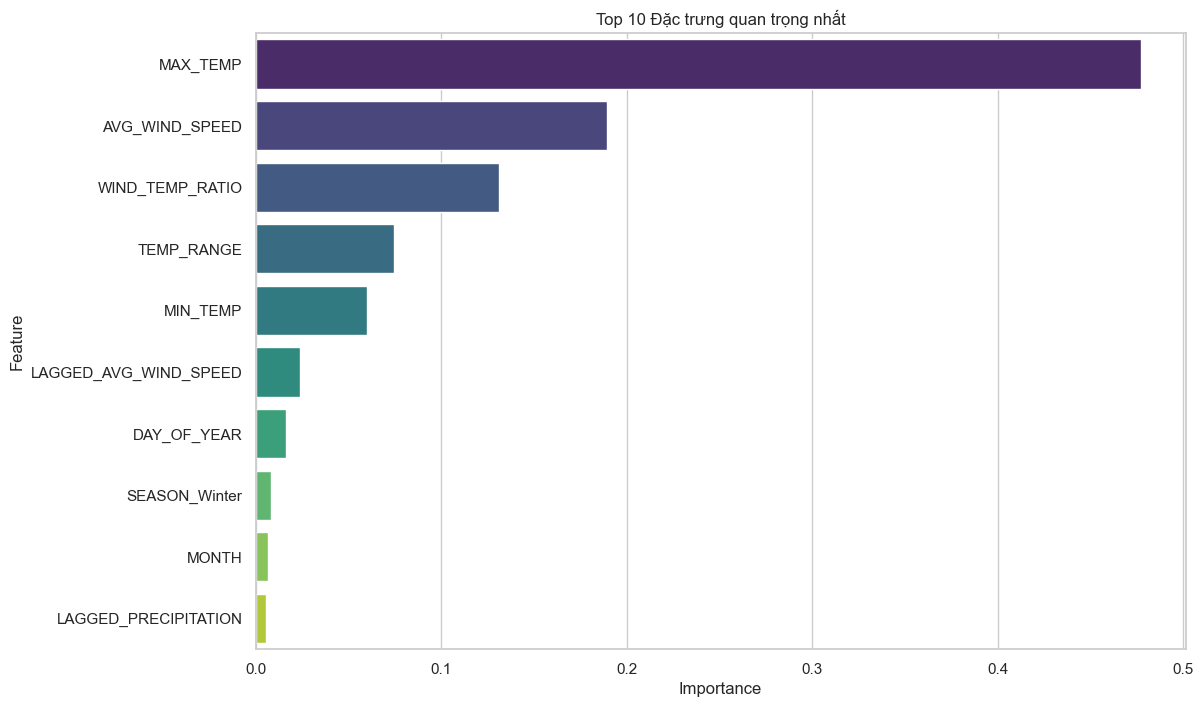

In [10]:
# Lấy độ quan trọng từ mô hình
importances = model.feature_importances_
feature_names = X.columns

# Tạo DataFrame để dễ xem
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("--- Mức độ quan trọng của các đặc trưng ---")
print(feature_importance_df.head(10))

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Đặc trưng quan trọng nhất')
plt.show()